# K-Means w/ PCA on Pneumonia X-Rays

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import os
import time

In [2]:
from sklearn.preprocessing import normalize

In [3]:
#Helper function to get cluster_plot
def get_cluster_plot(rows, Kmus): 
    '''
    : get a plot of what different clusters represent
    : takes as input the cluster location matrix
    '''
    fig,axs = plt.subplots(rows,5, figsize = (15,9))
    for i in range(len(Kmus)):
        cluster = Kmus[i].reshape(256,-1) * 255
        axs[i//5][i%5].imshow(cluster, cmap = plt.cm.binary)
        axs[i//5][i%5].set_title(f'Cluster {i + 1}')

## Setup: Reading and formatting images

The data used in this notebook consist of lung x-rays from healthy individuals and individuals infected with pneumonia. Although the data comes with the identifying labels, we will remove them in order to create an unlabeled dataset. Images will also be resized to 256x256.

In [15]:
#Function to process .jpeg images into array for KMeans
def process_imgKMeans():
    print("Reading images for KMeans")
    array = []
    dim = (256, 256)
    images = glob.glob("../NORMAL/*.jpeg")#"./chest_xrtrain/NORMAL/*.jpeg")
    for image_file in images:
        # Resize images and remove RGB
        image = cv2.resize(cv2.imread(image_file), dim, interpolation = cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        array.append(image)

    images = glob.glob("../PNEUMONIA/*.jpeg")#"./chest_xray/train/PNEUMONIA/*.jpeg")
    for image_file in images:
        # Resize images and remove RGB
        image = cv2.resize(cv2.imread(image_file), dim, interpolation = cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        array.append(image)

    return array

In [16]:
#Function to process .jpeg images into array for PCA
def process_imgPCA():
    print("Reading images for PCA")
    array = []
    dim = (256, 256)
    images = glob.glob("../NORMAL/*.jpeg")#"./chest_xray/train/NORMAL/*.jpeg")
    for image_file in images:
        image = cv2.resize(cv2.imread(image_file), dim, interpolation = cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).T
        array.append(image)

    images = glob.glob("../PNEUMONIA/*.jpeg")#"./chest_xray/train/PNEUMONIA/*.jpeg")
    for image_file in images:
        image = cv2.resize(cv2.imread(image_file), dim, interpolation = cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).T
        array.append(image)
    
    return array

In [17]:
#processing images
x_raysKMeans = process_imgKMeans()
x_raysPCA = process_imgPCA()

Reading images for KMeans
Reading images for PCA


In [18]:
#convert to arrays
x_raysKMeans, x_raysPCA = np.array(x_raysKMeans), np.array(x_raysPCA)

## Visualizing the data:

We can plot images of healthy lungs and infected lungs to visualize the difference between both.

C:\Users\GIRISH~1\AppData\Local\Temp/ipykernel_7292/4038120198.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


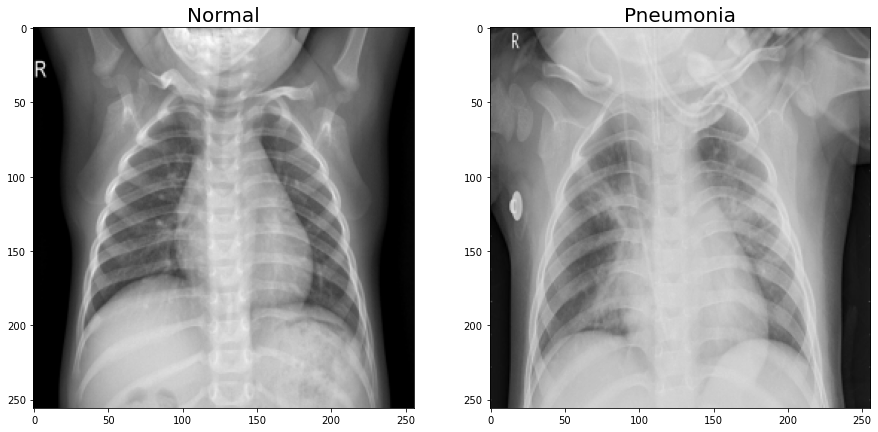

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(15,9))
axs[0].set_title("Normal", fontsize="20")
axs[0].imshow(x_raysKMeans[2].reshape(256,256), cmap=plt.get_cmap('gray'))
axs[1].set_title("Pneumonia", fontsize="20")
axs[1].imshow(x_raysKMeans[-2].reshape(256,256), cmap=plt.get_cmap('gray'))

fig.show()

From the images above, we can clearly see that lungs with pneumonia look more cloudy than healthy lungs. When observing the images, the cloudiness of the lungs are a common difference between normal and infected lungs.

In [20]:
#shuffle
np.random.shuffle(x_raysKMeans)
np.random.shuffle(x_raysPCA)

In [21]:
#Reshape array to 1D nparray
x_raysKMeans = x_raysKMeans.reshape(5216, -1)/255

In [22]:
#Reshape array to 1D nparray and take transpose to create column vectors
x_raysPCA = x_raysPCA.reshape(5216, -1)/255
x_raysPCA = x_raysPCA.T

## K-means:

Using K-means, we can attempt to find some underlying patterns for our images by assigning our images to certain clusters. We know that the dataset contains x-rays of both healthy and infected lungs and from the visualization, we can clearly see a difference in cloudiness. So we can train our model to try and identify this difference.

In [23]:
#Helper functions for KMeans
def calcSqDistances(X, Kmus):
    res = np.zeros((X.shape[0], Kmus.shape[0]))
    for i in range(X.shape[0]):
        for j in range(Kmus.shape[0]):
            res[i, j] = np.linalg.norm(X[i] - Kmus[j])
    return res

def determineRnk(sqDmat):
    Rnk = np.tile(0, (sqDmat.shape[0], sqDmat.shape[1]))
    for i in range(sqDmat.shape[0]):
        index = np.argmin(sqDmat[i])
        Rnk[i][index] = 1
    
    return Rnk

def recalcMus(X, Rnk):
    recalc = np.zeros((Rnk.shape[1], X.shape[1]))
    
    for i in range(Rnk.shape[1]):
        recalc[i,:] = np.sum((np.array([Rnk[:,i]]).T) * X, axis = 0)/(np.sum(Rnk[:,i], axis = 0))
    return recalc

In [24]:
def runKMeans(matrix, K):
    #load data file specified by fileString from Bishop book
    start = time.time()
    X = matrix

    #determine and store data set information
    N, D = X.shape

    #allocate space for the K mu vectors
    Kmus = np.zeros((K, D))

    #initialize cluster centers by randomly picking points from the data
    rand_inds = np.random.permutation(N)
    Kmus = X[rand_inds[0:K],:]

    #specify the maximum number of iterations to allow
    maxiters = 1000

    for iter in range(maxiters):
        #assign each data vector to closest mu vector as per Bishop (9.2)
        #do this by first calculating a squared distance matrix where the n,k entry
        #contains the squared distance from the nth data vector to the kth mu vector

        #sqDmat will be an N-by-K matrix with the n,k entry as specfied above
        sqDmat = calcSqDistances(X, Kmus)

        #given the matrix of squared distances, determine the closest cluster
        #center for each data vector

        #R is the "responsibility" matrix
        #R will be an N-by-K matrix of binary values whose n,k entry is set as
        #per Bishop (9.2)
        #Specifically, the n,k entry is 1 if point n is closest to cluster k,
        #and is 0 otherwise
        Rnk = determineRnk(sqDmat)

        KmusOld = Kmus
#         plotCurrent(X, Rnk, Kmus)
#         time.sleep(1)

        #recalculate mu values based on cluster assignments as per Bishop (9.4)
        Kmus = recalcMus(X, Rnk)





        #check to see if the cluster centers have converged.  If so, break.
        diff = np.sum(np.abs(KmusOld.reshape((-1, 1)) - Kmus.reshape((-1, 1))))
        print(diff)
        if diff < 1e-6:
            print(iter)
            break

    # plotCurrent(X, Rnk, Kmus)
    end = time.time()
    seconds = end - start
    print("Total time: {}".format(seconds))
    return Kmus, Rnk, seconds

Running K-means for 2 clusters

In [25]:
xray_kmeans, kmeans_rnk, s = runKMeans(x_raysKMeans, 2)

11784.201456327508
894.0230834966475
219.54639441903691
114.97959608539183
84.01903170440696
51.13013781738902
42.24729973951297
44.60655888033182
48.430383813517714
54.20731750375624
34.84137871504597
16.263474389238603
27.41938466167305
20.772565726567525
11.325282741050621
3.9674615125833794
6.677922877439563
5.524157894330103
0.0
18
Total time: 55.78094673156738


## Results from K-means:

We can try to cluster K-means with 2 clusters (normal and pneumonia).

In [26]:
print(xray_kmeans)

[[0.16427214 0.16929521 0.18952311 ... 0.06154821 0.06332491 0.07058376]
 [0.21668904 0.22654227 0.24546137 ... 0.07835704 0.0792794  0.08656882]]


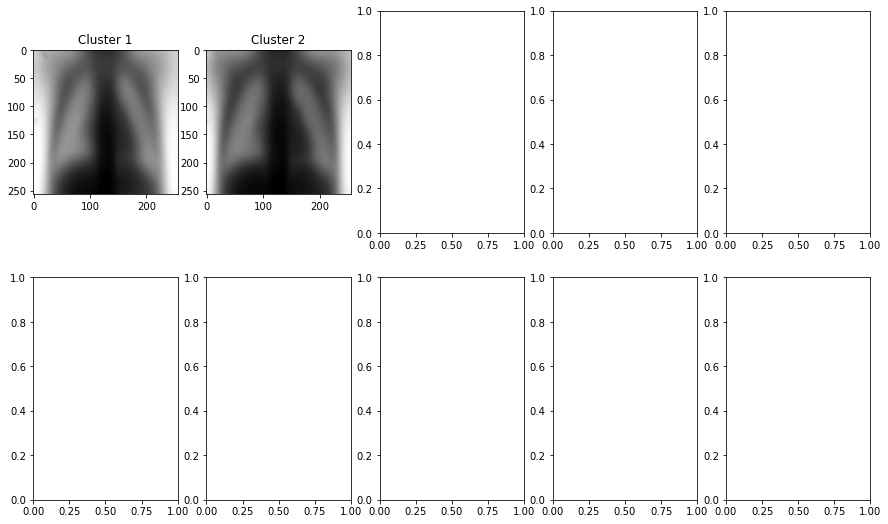

In [27]:
get_cluster_plot(2, xray_kmeans)

C:\Users\GIRISH~1\AppData\Local\Temp/ipykernel_7292/1571692315.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


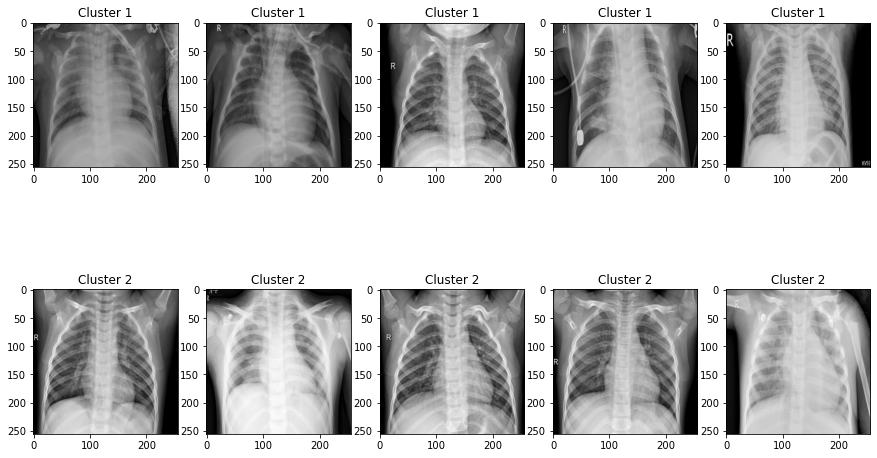

In [28]:
def get_indices(rnk, num_indices):
    
    indices = []
    clusters = rnk.shape[1]
    for i in range(clusters):
      indices.append([])

    i = 0
    j = 0
    while i < num_indices*clusters:
        val = max(rnk[j])
        pos = np.where(rnk[j] == val)[0][0]
        if (len(indices[pos]) != 5):
            indices[pos].append(j)
            i += 1

        j += 1
        
    return indices

indices = get_indices(kmeans_rnk, 5)

def view_images(indices):
    clusters = len(indices)
    num_images = len(indices[0])
    fig, axs = plt.subplots(clusters, num_images, figsize=(15,9))
    for col in range(num_images):
        for i in range(clusters):
            axs[i][col].set_title(f"Cluster {i+1}", fontsize="12")
            axs[i][col].imshow(x_raysKMeans[indices[i][col]].reshape(256,256), cmap=plt.get_cmap('gray'))
    fig.show()
    
view_images(indices)

4 clusters.

In [30]:
four_clusters, kmeans_rnk, four_s = runKMeans(x_raysKMeans, 4)

22438.222033169317
3191.3355199555713
1952.774321132001
1347.529809627248
1247.292609696049
1165.3173741065664
845.320861238668
625.5972186605812
603.1062926408165
521.6978964687632
481.66087626724914
480.3547447572607
401.34733697943483
354.52420434688025
281.7497528049541
237.00626317933296
194.72582837808196
167.83531072804502
156.3322137972856
108.52954840658394
104.76796917483733
73.39065319377613
53.38597574659568
68.81708272125672
53.5832079044746
31.138864617335873
36.17572393422458
51.44135646978011
55.407521323821136
32.125518664958776
25.95727308759481
0.0
31
Total time: 184.11403560638428


C:\Users\GIRISH~1\AppData\Local\Temp/ipykernel_7292/1571692315.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


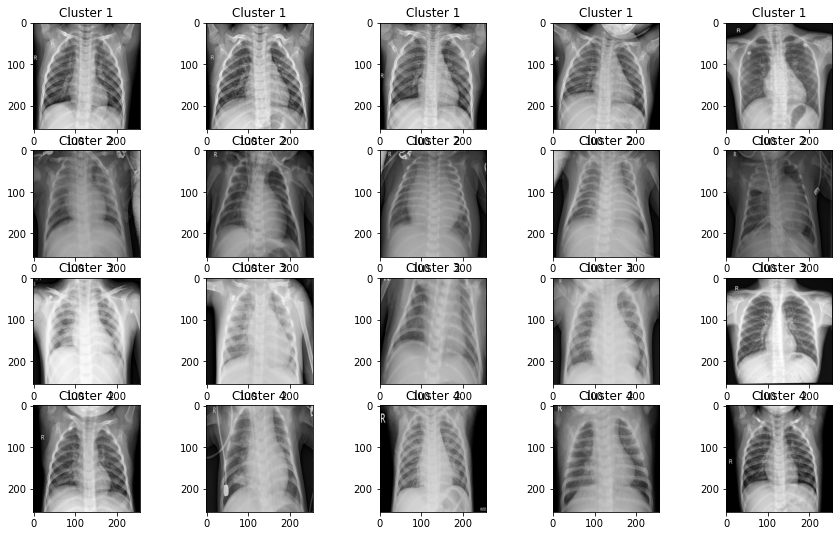

In [31]:
indices = get_indices(kmeans_rnk, 5)
view_images(indices)

## PCA:


In [32]:
def eigsort(V, eigvals):
    
    # Sort the eigenvalues from largest to smallest. Store the sorted
    # eigenvalues in the column vector lambd.
    lohival = np.sort(eigvals)
    lohiindex = np.argsort(eigvals)
    lambd = np.flip(lohival)
    index = np.flip(lohiindex)
    Dsort = np.diag(lambd)
    
    # Sort eigenvectors to correspond to the ordered eigenvalues. Store sorted
    # eigenvectors as columns of the matrix vsort.
    M = np.size(lambd)
    Vsort = np.zeros((M, M))
    for i in range(M):
        Vsort[:,i] = V[:,index[i]]
    return Vsort, Dsort, lambd

#Helper function to normalize matrix

def normc(Mat):
    return normalize(Mat, norm='l2', axis=0)

#Helper function to plot skree plot of lambdas

def skree(lambd):
    plt.plot(np.arange(len(lambd)) + 1, lambd, 'ro-', linewidth = 2)
    plt.title("Scree Plot")
    plt.xlabel("Principal Component")
    plt.ylabel("Eigenvalue")
    return

#Helper function to return variance explained and cumulataive sum of variance

def explained_variance(eigen_values):

  #explains how much of the data each component describes 
    var_exp = [(i/sum(eigen_values))*100 for i in eigen_values]
  
  #cumsum of var_exp for easier visualization
    cumsum_var = np.cumsum(var_exp)

    return var_exp, cumsum_var

#Helper function to viewcolumn vectors

def viewcolumn(columnvector):
    plt.imshow(columnvector.reshape(
        [256, 256], order='F'), cmap=plt.get_cmap('gray'))
    plt.show()

#Helper function to retrive indice where threshold variance is explained
#e.g. returns i = 4 if first 5 components explain threshold variance

def indexfinder(cumsum, threshold):
    for i in range(len(cumsum)):
        if cumsum[i] >= threshold:
            return i

In [33]:
x_raysPCA.shape

(65536, 5216)

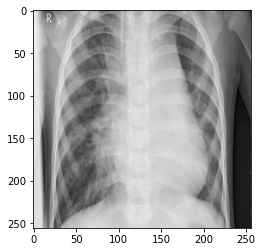

In [34]:
viewcolumn(x_raysPCA[:,0])

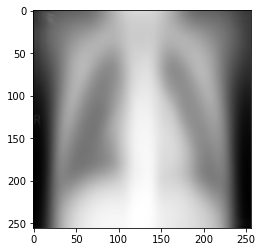

In [35]:
mean_xrays = np.mean(x_raysPCA, axis = 1)[:,None]
viewcolumn(mean_xrays)

In [36]:
A = (x_raysPCA - mean_xrays).real.astype(np.float32)
cov = np.divide(A.T@A, 5216)

In [37]:
eigvals, V = np.linalg.eig(cov)
Vsort, Dsort, lambd = eigsort(V, eigvals)

In [38]:
U = A @ Vsort
U = normc(U)

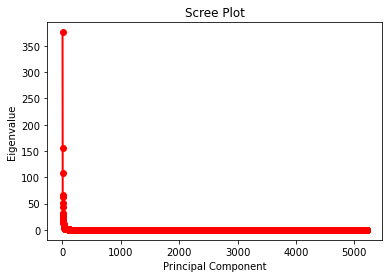

In [39]:
#Skree plot
#Elbow at near right angle, extreme drop off of variance explained by components 
#following elbow
skree(lambd)

In [40]:
exp, cumsum = explained_variance(eigvals)
cumsum

array([ 25.24716783,  35.67791558,  42.91349136, ...,  99.99959884,
        99.99979966, 100.        ])

In [41]:
indexfinder(cumsum, 96)

646

In [42]:
reduced_U = U[:625]
x_rays_temp = x_raysPCA[:,:625] - mean_xrays

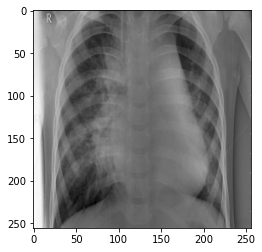

(65536, 625)

In [43]:
viewcolumn(x_rays_temp[:,0])
reduced_U.shape
x_rays_temp.shape

In [44]:
reduced_xrays = reduced_U.T @ x_rays_temp[:625]

In [45]:
zhat = U[:,:625] @ reduced_xrays[:625] + mean_xrays

In [46]:
#shape comparisons
reduced_xrays.shape, x_raysPCA.shape, zhat.shape

((5216, 625), (65536, 5216), (65536, 625))

## K-means with PCA:

We saw that K-means for 2 clusters was okay, but what about K-means with PCA for 2 clusters?

In [47]:
#KMeans on PCA reduced xrays, significantly faster
reduced_test, red_rnk, red_s = runKMeans(reduced_xrays, 2)

17.315161795505638
2.487185327860236
0.8099610493127989
0.8682158359401649
1.4038380246525224
2.308115428848728
3.8456006420570783
7.421964259468187
17.09810384084503
39.00656186472735
59.124864941550804
40.99554866068296
38.67683299181653
26.490519300339344
18.618662958761295
18.20622589860739
27.356645592808427
29.217218452962474
17.152744426876833
10.595369816947494
21.665504239539008
12.213186780755445
0.0
22
Total time: 1.9670004844665527


In [48]:
print(reduced_test.shape)

(2, 625)


C:\Users\GIRISH~1\AppData\Local\Temp/ipykernel_7292/1571692315.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


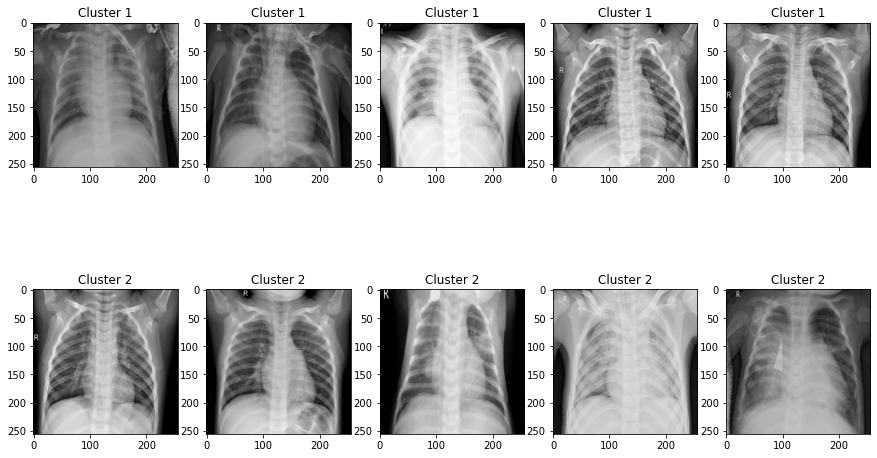

In [49]:
#cluster1, cluster2
indices = get_indices(red_rnk, 5)
view_images(indices)

## Comparing Runtime for K-means w/ and w/o PCA

In [50]:
#Time test
runKMeans(x_raysKMeans[:625], 10)

41989.43296289901
8620.427193891388
6446.141729033059
5464.221411244555
4192.274570880709
3604.3730518158354
3064.737660520164
2131.86445594925
2409.486929130735
1918.2186061536233
1055.5905417460922
945.2642259389604
703.0118981678886
182.95954082075798
0.0
14
Total time: 26.7606942653656


(array([[0.35228758, 0.36085694, 0.37058824, ..., 0.15831518, 0.15112564,
         0.15809731],
        [0.06311275, 0.06519608, 0.11421569, ..., 0.0129902 , 0.01348039,
         0.01495098],
        [0.17988796, 0.1870028 , 0.21613445, ..., 0.09243697, 0.10011204,
         0.11176471],
        ...,
        [0.22443092, 0.25043949, 0.27076854, ..., 0.0182105 , 0.01604688,
         0.01685824],
        [0.20309598, 0.2120399 , 0.20612315, ..., 0.14035088, 0.13911249,
         0.14785002],
        [0.15478662, 0.15726644, 0.16730104, ..., 0.07525952, 0.07733564,
         0.09059977]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 26.7606942653656)

In [51]:
runKMeans(reduced_xrays, 10)

259.76446405792
208.66420485919053
196.02977181130115
257.4419212259405
215.12850298754364
121.7905612362621
78.11963296514907
98.6130553054291
40.46944121682202
28.082356650392917
19.93884219666579
12.098233775339882
13.003688590079399
18.499178386262724
9.660803113352799
10.46675527209393
2.245000158295521
1.7233599858686586
1.6544244292811336
3.2094178576311494
5.387388871230289
8.132697179830801
4.890304124403688
5.479424174700409
4.5577497923587655
3.909293719904835
5.267487758157892
8.495983588640579
6.7452331370213825
1.4613025676178837
0.8421317291679262
0.0407993637047061
0.03590495832183316
0.02140653988623684
0.015290013864525848
0.026797456696548407
0.011329790969491547
0.006040267432941419
0.0
38
Total time: 15.083996534347534


(array([[ 6.20938626e+00, -9.19031300e-01, -1.06286774e+00, ...,
         -1.49264590e-01,  5.49019404e-01, -1.12332261e+00],
        [ 4.56488297e-01, -3.29917938e-02, -2.58333868e-02, ...,
         -5.96953478e-02,  1.03440771e-01, -3.78307185e-02],
        [ 4.75211252e-02, -7.57189618e-03, -9.60408760e-03, ...,
          8.03534152e-04,  3.71681590e-03, -1.00857060e-02],
        ...,
        [-6.38278040e-02,  8.16181233e-03,  1.22021812e-02, ...,
          1.36796926e-03, -6.27904595e-03,  1.23421338e-02],
        [ 1.74334587e+00, -2.99086522e-01, -3.41304434e-01, ...,
         -8.03988500e-03,  1.22024436e-01, -3.57228000e-01],
        [-1.73191394e+00,  3.03721595e-01,  3.55165444e-01, ...,
          6.46344669e-03, -9.92142030e-02,  3.68366231e-01]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 1, 0],
        ...,
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0]]),
 15.083996534347

In [53]:
normal_times, reduced_times = [], []
for k in range(2, 16):
    mus, rnk, s = runKMeans(x_raysKMeans[:625], k)
    normal_times.append(s)
    rmus, rrnk, rs = runKMeans(reduced_xrays, k)
    reduced_times.append(rs)

12400.376278780017
1700.758654080811
798.4421123149749
710.5651684802627
844.1776298200718
703.1614997970859
421.7952748323813
397.83604331365103
292.86872496956045
332.00371816618645
236.5111195260986
207.20240214288918
175.71041635528195
160.81967123098593
0.0
14
Total time: 5.770002365112305
83.73619614628768
62.3072447402043
63.028828532070186
51.00973412956608
61.69347474862944
46.18047811810636
35.62520341840043
28.725047565810303
0.0
8
Total time: 0.8299961090087891
15766.077526573412
4340.91306166683
4826.344171325826
2449.3465068428663
1489.3595535316133
1076.7195334527983
820.3825528736255
693.4623379127838
573.7918319048505
460.687565178239
247.92770143512504
308.0810179729332
379.146079702029
148.96494395402968
186.4980652403668
44.29806005657058
0.0
16
Total time: 9.486011981964111
28.78609875813557
24.58601154162399
55.906202558520086
92.37927462141286
123.26305034969035
119.98801752862539
99.98620449842076
79.0749645715099
56.06030633184852
49.284946407565315
14.82198238

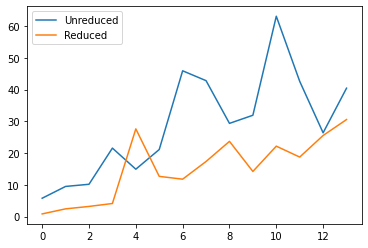

In [54]:
plt.plot(normal_times, label = "Unreduced")
plt.plot(reduced_times, label = "Reduced")
plt.xlabel = ('K Clusters')
plt.ylabel = ("Time (seconds)")
plt.legend()

So, not only was it able to cluster the images to 2 clusters, but it also (on average) runs faster.